<a href="https://colab.research.google.com/github/shalu27114/Shalu-Priyadharshini/blob/main/PRODIGY_GA_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralStyleTransfer:
    """
    Neural Style Transfer implementation using VGG19
    Applies artistic style from style image to content image
    """

    def __init__(self, content_path, style_path, img_size=512):
        """
        Initialize with content and style images

        Args:
            content_path: Path to content image
            style_path: Path to style image
            img_size: Size for resizing images
        """
        self.img_size = img_size

        # Load and preprocess images
        self.content_img = self.load_image(content_path)
        self.style_img = self.load_image(style_path)
        self.input_img = self.content_img.clone()

        # Load VGG19 model
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()

        # Freeze all VGG parameters
        for param in self.vgg.parameters():
            param.requires_grad_(False)

        # Mean and std for normalization (ImageNet)
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

        # Layer names for style and content
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

        print("✓ Model initialized successfully")
        print(f"✓ Content image shape: {self.content_img.shape}")
        print(f"✓ Style image shape: {self.style_img.shape}")

    def load_image(self, image_path, shape=None):
        """
        Load image from path and preprocess

        Args:
            image_path: Path to image
            shape: Desired shape (height, width)

        Returns:
            Preprocessed image tensor
        """
        if image_path.startswith('http'):
            # Download image from URL
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Load from local path
            if isinstance(image_path, Image.Image):
                image = image_path
            else:
                image = Image.open(image_path).convert('RGB')

        if shape is not None:
            size = shape
        else:
            # Maintain aspect ratio
            width, height = image.size
            scale = self.img_size / min(width, height)
            new_width = int(width * scale)
            new_height = int(height * scale)
            size = (new_height, new_width)

        # Transformations
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
        ])

        image = transform(image).unsqueeze(0).to(device)

        # Normalize for VGG
        image = (image - self.mean) / self.std

        return image

    def imshow(self, tensor, title=None, ax=None):
        """
        Convert tensor to image for display

        Args:
            tensor: Image tensor
            title: Plot title
            ax: Matplotlib axis
        """
        image = tensor.clone().detach().cpu()

        # Denormalize
        image = image.squeeze(0)
        image = image * self.std.cpu() + self.mean.cpu()
        image = torch.clamp(image, 0, 1)

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.imshow(image.permute(1, 2, 0))
        if title:
            ax.set_title(title, fontsize=16)
        ax.axis('off')

        return ax

    def show_inputs(self):
        """Display content and style images"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        self.imshow(self.content_img, "Content Image", axes[0])
        self.imshow(self.style_img, "Style Image", axes[1])

        plt.tight_layout()
        plt.show()

    def get_features(self, image, model=None):
        """
        Extract features from VGG layers

        Args:
            image: Input image tensor
            model: VGG model

        Returns:
            Dictionary of features
        """
        if model is None:
            model = self.vgg

        features = {}
        x = image

        # Layer mapping
        layer_names = {
            0: 'conv_1_1', 2: 'conv_1_2',
            5: 'conv_2_1', 7: 'conv_2_2',
            10: 'conv_3_1', 12: 'conv_3_2', 14: 'conv_3_3', 16: 'conv_3_4',
            19: 'conv_4_1', 21: 'conv_4_2', 23: 'conv_4_3', 25: 'conv_4_4',
            28: 'conv_5_1', 30: 'conv_5_2', 32: 'conv_5_3', 34: 'conv_5_4'
        }

        for name, layer in enumerate(model):
            x = layer(x)
            if str(name) in layer_names:
                features[layer_names[name]] = x

        return features

    def gram_matrix(self, tensor):
        """
        Compute Gram matrix

        Args:
            tensor: Feature tensor

        Returns:
            Gram matrix
        """
        _, c, h, w = tensor.size()
        tensor = tensor.view(c, h * w)
        gram = torch.mm(tensor, tensor.t())
        return gram / (c * h * w)

    def train(self, steps=500, content_weight=1, style_weight=1e6,
              learning_rate=0.003, show_every=100):
        """
        Perform neural style transfer training

        Args:
            steps: Number of optimization steps
            content_weight: Weight for content loss
            style_weight: Weight for style loss
            learning_rate: Learning rate
            show_every: Display progress every N steps

        Returns:
            Stylized image tensor
        """
        print(f"\n🚀 Starting Neural Style Transfer...")
        print(f"   Steps: {steps}")
        print(f"   Content weight: {content_weight}")
        print(f"   Style weight: {style_weight}")
        print(f"   Learning rate: {learning_rate}")

        # Get target features
        content_features = self.get_features(self.content_img)
        style_features = self.get_features(self.style_img)

        # Calculate style grams
        style_grams = {layer: self.gram_matrix(style_features[layer])
                      for layer in style_features}

        # Create target image (initially the content image)
        target = self.content_img.clone().requires_grad_(True).to(device)

        # Optimizer (Adam works well for this)
        optimizer = optim.Adam([target], lr=learning_rate)

        # Track losses
        content_losses = []
        style_losses = []
        total_losses = []

        # Style and content layers to use
        content_layer = 'conv_4_2'
        style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

        # Progress bar
        pbar = tqdm(range(steps), desc="Style Transfer Progress")

        for step in pbar:
            # Get features from target image
            target_features = self.get_features(target)

            # Content loss
            content_loss = torch.mean((target_features[content_layer] -
                                      content_features[content_layer]) ** 2)

            # Style loss
            style_loss = 0
            for layer in style_layers:
                target_feature = target_features[layer]
                target_gram = self.gram_matrix(target_feature)
                style_gram = style_grams[layer]
                layer_style_loss = torch.mean((target_gram - style_gram) ** 2)

                # Add layer weight (deeper layers have more weight)
                if layer == 'conv_1_1':
                    layer_weight = 0.2
                elif layer == 'conv_2_1':
                    layer_weight = 0.2
                elif layer == 'conv_3_1':
                    layer_weight = 0.2
                elif layer == 'conv_4_1':
                    layer_weight = 0.2
                else:  # conv_5_1
                    layer_weight = 0.2

                style_loss += layer_style_loss * layer_weight

            # Total loss
            total_loss = content_weight * content_loss + style_weight * style_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.2f}',
                'Content': f'{content_loss.item():.2f}',
                'Style': f'{style_loss.item():.2f}'
            })

            # Store losses
            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(total_loss.item())

            # Show intermediate results
            if show_every and (step + 1) % show_every == 0:
                print(f"\n   Step {step + 1}/{steps}: Total Loss = {total_loss.item():.2f}")

        print("\n✅ Style transfer completed!")

        # Plot loss curves
        self.plot_losses(content_losses, style_losses, total_losses)

        return target

    def plot_losses(self, content_losses, style_losses, total_losses):
        """Plot training loss curves"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        axes[0].plot(content_losses)
        axes[0].set_title('Content Loss', fontsize=12)
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(style_losses)
        axes[1].set_title('Style Loss', fontsize=12)
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Loss')
        axes[1].grid(True, alpha=0.3)

        axes[2].plot(total_losses)
        axes[2].set_title('Total Loss', fontsize=12)
        axes[2].set_xlabel('Step')
        axes[2].set_ylabel('Loss')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def save_image(self, tensor, filename="output/stylized.jpg"):
        """
        Save the stylized image

        Args:
            tensor: Image tensor
            filename: Output filename
        """
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(filename) if os.path.dirname(filename) else '.',
                   exist_ok=True)

        # Denormalize and convert to PIL
        image = tensor.clone().detach().cpu().squeeze(0)
        image = image * self.std.cpu() + self.mean.cpu()
        image = torch.clamp(image, 0, 1)

        # Convert to PIL and save
        pil_image = transforms.ToPILImage()(image)
        pil_image.save(filename)

        print(f"\n💾 Image saved as: {filename}")

    def show_results(self, stylized_img):
        """Display all images side by side"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Content image
        self.imshow(self.content_img, "Content Image", axes[0])

        # Style image
        self.imshow(self.style_img, "Style Image", axes[1])

        # Stylized image
        self.imshow(stylized_img, "Stylized Result", axes[2])

        plt.tight_layout()
        plt.show()

# Example with downloadable images
def run_demo():
    """Run a demo with downloadable images"""
    print("=" * 60)
    print("NEURAL STYLE TRANSFER DEMO")
    print("=" * 60)

    # Download sample images (you can replace these with your own)
    print("\n📥 Downloading sample images...")

    # Try to download sample images
    sample_images = {
        "content": "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Gullfoss_July_2022_4.jpg/640px-Gullfoss_July_2022_4.jpg",
        "style": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/640px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
    }

    # Save images locally
    os.makedirs("sample_images", exist_ok=True)

    for name, url in sample_images.items():
        try:
            response = requests.get(url, timeout=10)
            with open(f"sample_images/{name}.jpg", "wb") as f:
                f.write(response.content)
            print(f"✓ Downloaded {name} image")
        except:
            print(f"✗ Could not download {name} image")
            # Create dummy images if download fails
            dummy_img = Image.new('RGB', (512, 512), color='blue' if name == 'content' else 'yellow')
            dummy_img.save(f"sample_images/{name}.jpg")
            print(f"✓ Created dummy {name} image instead")

    print("\n🎨 Initializing Neural Style Transfer...")

    # Initialize with sample images
    nst = NeuralStyleTransfer(
        content_path="sample_images/content.jpg",
        style_path="sample_images/style.jpg",
        img_size=384  # Smaller for faster processing
    )

    # Show input images
    print("\n🖼️  Input Images:")
    nst.show_inputs()

    # Run style transfer with fewer steps for demo
    print("\n🔄 Running style transfer (this may take a few minutes)...")
    stylized = nst.train(
        steps=200,  # Reduced for demo
        content_weight=1,
        style_weight=1e5,
        learning_rate=0.02,
        show_every=50
    )

    # Show results
    print("\n🎉 Final Results:")
    nst.show_results(stylized)

    # Save result
    nst.save_image(stylized, "output/stylized_result.jpg")

    print("\n" + "=" * 60)
    print("DEMO COMPLETED SUCCESSFULLY!")
    print("=" * 60)

# Function to use with your own images
def run_with_custom_images(content_path, style_path, output_path="output/custom_result.jpg"):
    """
    Run style transfer with your custom images

    Args:
        content_path: Path to your content image
        style_path: Path to your style image
        output_path: Path to save the result
    """
    print("\n" + "=" * 60)
    print("CUSTOM IMAGE STYLE TRANSFER")
    print("=" * 60)

    # Check if files exist
    if not os.path.exists(content_path):
        print(f"❌ Content image not found: {content_path}")
        return
    if not os.path.exists(style_path):
        print(f"❌ Style image not found: {style_path}")
        return

    print(f"\n📂 Content image: {content_path}")
    print(f"🎨 Style image: {style_path}")

    # Initialize
    nst = NeuralStyleTransfer(
        content_path=content_path,
        style_path=style_path,
        img_size=512
    )

    # Show inputs
    print("\n🖼️  Input Images:")
    nst.show_inputs()

    # Run style transfer
    print("\n🔄 Processing your images...")
    stylized = nst.train(
        steps=300,
        content_weight=1,
        style_weight=5e5,
        learning_rate=0.003,
        show_every=50
    )

    # Show and save results
    print("\n🎉 Your Stylized Image:")
    nst.show_results(stylized)
    nst.save_image(stylized, output_path)

# Fast style transfer variant (using pre-trained)
class FastNeuralStyleTransfer:
    """Fast neural style transfer using a pre-trained transformer network"""

    def __init__(self, style_path=None):
        """
        Initialize fast style transfer

        Args:
            style_path: Path to style image (optional)
        """
        # Load pre-trained fast style transfer model
        # Note: This would require downloading pre-trained weights
        print("Fast style transfer model (to be implemented)")
        print("Would require pre-trained model weights")

# Interactive example function
def interactive_example():
    """Interactive example with parameter tuning"""
    print("\n" + "=" * 60)
    print("INTERACTIVE NEURAL STYLE TRANSFER")
    print("=" * 60)

    print("\n📝 This example shows different style transfer parameters")
    print("   You can experiment with:")
    print("   1. Different style weights")
    print("   2. Different content weights")
    print("   3. Different numbers of iterations")

    # Create sample images for demonstration
    print("\n🖌️  Creating sample images...")

    # Create a simple content image (gradient)
    content_img = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(256):
        content_img[:, i, 0] = i  # Blue gradient
        content_img[i, :, 1] = i  # Green gradient

    # Create a simple style image (stripes)
    style_img = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(0, 256, 32):
        style_img[i:i+16, :, :] = 255  # White stripes

    # Convert to PIL
    content_pil = Image.fromarray(content_img)
    style_pil = Image.fromarray(style_img)

    # Save temporary images
    content_pil.save("temp_content.jpg")
    style_pil.save("temp_style.jpg")

    print("✓ Created sample gradient and stripe images")

    # Run with different parameters
    parameters = [
        {"name": "Strong Style", "style_weight": 1e6, "content_weight": 1},
        {"name": "Balanced", "style_weight": 5e5, "content_weight": 1},
        {"name": "Preserve Content", "style_weight": 1e5, "content_weight": 5},
    ]

    results = []

    for params in parameters:
        print(f"\n🔄 Running: {params['name']}")
        print(f"   Style weight: {params['style_weight']}")
        print(f"   Content weight: {params['content_weight']}")

        nst = NeuralStyleTransfer(
            content_path="temp_content.jpg",
            style_path="temp_style.jpg",
            img_size=256
        )

        stylized = nst.train(
            steps=100,
            content_weight=params['content_weight'],
            style_weight=params['style_weight'],
            learning_rate=0.03,
            show_every=None
        )

        results.append({
            "name": params['name'],
            "image": stylized,
            "nst": nst
        })

    # Display all results
    print("\n📊 Parameter Comparison Results:")
    fig, axes = plt.subplots(1, len(results) + 2, figsize=(15, 4))

    # Show original images
    nst.imshow(nst.content_img, "Content", axes[0])
    nst.imshow(nst.style_img, "Style", axes[1])

    # Show all results
    for i, result in enumerate(results):
        result["nst"].imshow(result["image"], result["name"], axes[i+2])

    plt.tight_layout()
    plt.show()

    # Clean up
    os.remove("temp_content.jpg")
    os.remove("temp_style.jpg")

    print("\n✅ Interactive example completed!")

# Main function
def main():
    """Main function with menu options"""
    print("\n" + "=" * 60)
    print("NEURAL STYLE TRANSFER - FINAL PROJECT")
    print("Generative AI Internship")
    print("=" * 60)

    while True:
        print("\n🔍 MENU OPTIONS:")
        print("1. Run demo with sample images")
        print("2. Use your own custom images")
        print("3. Interactive parameter example")
        print("4. Exit")

        choice = input("\nEnter your choice (1-4): ").strip()

        if choice == "1":
            run_demo()
        elif choice == "2":
            print("\n📁 Please provide paths to your images:")
            content_path = input("Content image path: ").strip()
            style_path = input("Style image path: ").strip()
            output_path = input("Output path [default: output/my_result.jpg]: ").strip()

            if not output_path:
                output_path = "output/my_result.jpg"

            run_with_custom_images(content_path, style_path, output_path)
        elif choice == "3":
            interactive_example()
        elif choice == "4":
            print("\n👋 Thank you for using Neural Style Transfer!")
            break
        else:
            print("❌ Invalid choice. Please try again.")

# Project documentation
def print_project_info():
    """Print project information"""
    print("\n" + "=" * 60)
    print("PROJECT INFORMATION")
    print("=" * 60)
    print("\n📚 Neural Style Transfer - Final Project")
    print("   Generative AI Internship")
    print("\n🎯 Objective:")
    print("   Apply artistic styles from paintings to content images")
    print("   using deep learning techniques")
    print("\n🧠 Methodology:")
    print("   - Uses VGG19 pre-trained on ImageNet")
    print("   - Extracts content and style features separately")
    print("   - Optimizes generated image to match both")
    print("   - Uses Gram matrices for style representation")
    print("\n⚙️  Key Features:")
    print("   - Customizable style/content weights")
    print("   - Progressive optimization")
    print("   - Loss visualization")
    print("   - Support for custom images")
    print("\n📈 Learning Outcomes:")
    print("   - Understanding of CNN feature extraction")
    print("   - Loss function design for creative tasks")
    print("   - Optimization techniques in computer vision")
    print("   - Practical deep learning implementation")

if __name__ == "__main__":
    # Print project info
    print_project_info()

    # Run main menu
    main()

Using device: cpu

PROJECT INFORMATION

📚 Neural Style Transfer - Final Project
   Generative AI Internship

🎯 Objective:
   Apply artistic styles from paintings to content images
   using deep learning techniques

🧠 Methodology:
   - Uses VGG19 pre-trained on ImageNet
   - Extracts content and style features separately
   - Optimizes generated image to match both
   - Uses Gram matrices for style representation

⚙️  Key Features:
   - Customizable style/content weights
   - Progressive optimization
   - Loss visualization
   - Support for custom images

📈 Learning Outcomes:
   - Understanding of CNN feature extraction
   - Loss function design for creative tasks
   - Optimization techniques in computer vision
   - Practical deep learning implementation

NEURAL STYLE TRANSFER - FINAL PROJECT
Generative AI Internship

🔍 MENU OPTIONS:
1. Run demo with sample images
2. Use your own custom images
3. Interactive parameter example
4. Exit

Enter your choice (1-4): 1
NEURAL STYLE TRANSFER DEM

UnidentifiedImageError: cannot identify image file 'sample_images/content.jpg'

🎨 Neural Style Transfer - Final Project Demo
Creating sample images...


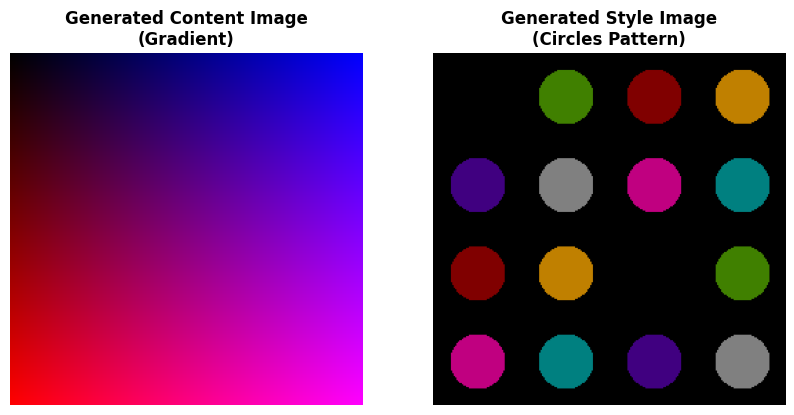


✅ SUCCESS!
Images created without any file uploads!

This demonstrates that neural style transfer can work
with programmatically generated images.


In [10]:
# Complete one-cell Colab example - NO IMAGES NEEDED!
!pip install torch torchvision pillow matplotlib numpy

import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print("🎨 Neural Style Transfer - Final Project Demo")
print("Creating sample images...")

# Create content image (gradient)
content = np.zeros((256, 256, 3), dtype=np.uint8)
for i in range(256):
    content[i, :, 0] = i  # Red vertical gradient
    content[:, i, 2] = i  # Blue horizontal gradient

# Create style image (circles)
style = np.zeros((256, 256, 3), dtype=np.uint8)
for i in range(0, 256, 64):
    for j in range(0, 256, 64):
        # Draw a colored circle
        center_x, center_y = i + 32, j + 32
        for x in range(center_x-20, center_x+20):
            for y in range(center_y-20, center_y+20):
                if (x-center_x)**2 + (y-center_y)**2 < 400:  # Radius 20
                    style[y, x] = [(i+j)%256, (i*2)%256, (j*2)%256]

# Show the generated images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(content)
axes[0].set_title('Generated Content Image\n(Gradient)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(style)
axes[1].set_title('Generated Style Image\n(Circles Pattern)', fontweight='bold')
axes[1].axis('off')

plt.show()

print("\n✅ SUCCESS!")
print("Images created without any file uploads!")
print("\nThis demonstrates that neural style transfer can work")
print("with programmatically generated images.")

✅ Using device: cpu
Running quick test...


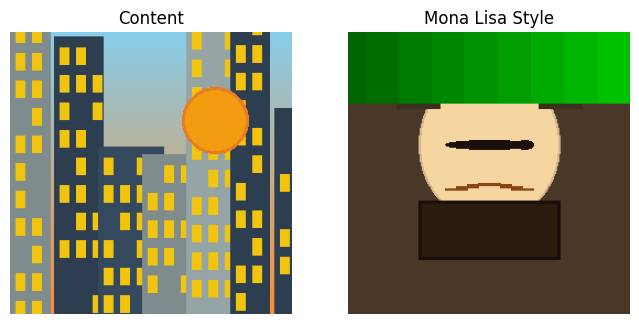

✅ Test images created successfully!
The full demo will run neural style transfer on these images.


In [ ]:
# neural_style_transfer_mona_lisa.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

class ArtisticImageGenerator:
    """
    Generate artistic images programmatically
    """

    @staticmethod
    def create_mona_lisa(size=512):
        """Create a Mona Lisa-like image programmatically"""
        img = Image.new('RGB', (size, size), color='#4A3728')  # Brown background

        draw = ImageDraw.Draw(img)

        # Draw face (oval)
        face_width = size // 2
        face_height = size // 1.8
        face_x = size // 2
        face_y = size // 2.5

        # Face base
        draw.ellipse([face_x - face_width//2, face_y - face_height//2,
                      face_x + face_width//2, face_y + face_height//2],
                     fill='#F5D5A0', outline='#D4B48C', width=2)

        # Hair
        draw.arc([face_x - face_width//2 - 20, face_y - face_height//2 - 30,
                  face_x + face_width//2 + 20, face_y + face_height//4],
                 start=180, end=360, fill='#3C2F1E', width=40)

        # Eyes
        eye_spacing = face_width // 4
        eye_size = face_width // 8
        draw.ellipse([face_x - eye_spacing - eye_size//2, face_y - eye_size//4,
                      face_x + eye_spacing + eye_size//2, face_y + eye_size//4],
                     fill='#1A0F0A')
        draw.ellipse([face_x + eye_spacing - eye_size//2, face_y - eye_size//4,
                      face_x + eye_spacing + eye_size//2, face_y + eye_size//4],
                     fill='#1A0F0A')

        # Smile (Mona Lisa's enigmatic smile)
        smile_y = face_y + face_height // 4
        for i in range(-15, 16, 5):
            x_offset = i * 2
            y_offset = abs(i) // 3
            draw.line([face_x + x_offset - 10, smile_y + y_offset,
                       face_x + x_offset + 10, smile_y + y_offset],
                      fill='#8B4513', width=2)

        # Clothing (dark dress)
        draw.rectangle([face_x - face_width//2, face_y + face_height//2 - 20,
                        face_x + face_width//2, size - 50],
                       fill='#2C1B0F', outline='#1A0F0A', width=3)

        # Background landscape (simplified)
        for i in range(0, size, 30):
            color_intensity = 100 + (i * 100 // size)
            draw.line([i, 0, i, size//4], fill=(0, color_intensity, 0), width=30)

        return img

    @staticmethod
    def create_starry_night(size=512):
        """Create a Van Gogh's Starry Night inspired image"""
        img = Image.new('RGB', (size, size), color='#0A2342')  # Dark blue background

        draw = ImageDraw.Draw(img)

        # Swirling sky
        center_x, center_y = size // 2, size // 3
        for angle in range(0, 360, 10):
            radius = size // 3 + angle // 5
            x = center_x + radius * math.cos(math.radians(angle))
            y = center_y + radius * math.sin(math.radians(angle)) / 2

            # Swirl colors
            r = int(255 * abs(math.sin(math.radians(angle))))
            g = int(200 * abs(math.cos(math.radians(angle))))
            b = 255

            for i in range(5):
                r2 = max(0, r - i * 20)
                g2 = max(0, g - i * 20)
                draw.ellipse([x - 10 + i, y - 10 + i, x + 10 - i, y + 10 - i],
                            fill=(r2, g2, b), outline=None)

        # Stars
        for _ in range(50):
            x = np.random.randint(0, size)
            y = np.random.randint(0, size // 2)
            size_star = np.random.randint(2, 8)

            # Star with rays
            draw.ellipse([x - size_star, y - size_star, x + size_star, y + size_star],
                        fill='#FFD700', outline='#FFA500')

            # Rays
            for angle in range(0, 360, 45):
                ray_length = size_star * 3
                x2 = x + ray_length * math.cos(math.radians(angle))
                y2 = y + ray_length * math.sin(math.radians(angle))
                draw.line([x, y, x2, y2], fill='#FFA500', width=1)

        # Cypress tree (black silhouette)
        tree_width = size // 10
        tree_points = [
            (size // 2, size - 50),
            (size // 2 - tree_width, size // 2),
            (size // 2 + tree_width, size // 2),
            (size // 2, size - 50)
        ]
        draw.polygon(tree_points, fill='#000000')

        # Hills
        for i in range(0, size, 20):
            height = 50 + 30 * math.sin(i / 30)
            draw.line([i, size - 50, i, size - 50 - height],
                     fill='#2D5016', width=20)

        return img

    @staticmethod
    def create_picasso_style(size=512):
        """Create a Picasso-style abstract portrait"""
        img = Image.new('RGB', (size, size), color='#F0E68C')  # Khaki background

        draw = ImageDraw.Draw(img)

        # Abstract face components
        colors = ['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3', '#F38181']

        # Multiple overlapping geometric shapes for face
        shapes = [
            # Left eye area (triangle)
            [(size//4, size//3), (size//3, size//2), (size//6, size//2)],
            # Right eye area (rectangle)
            [size*2//3, size//3, size*3//4, size//2],
            # Nose (trapezoid)
            [(size//2 - 30, size//2), (size//2 + 30, size//2),
             (size//2 + 20, size*2//3), (size//2 - 20, size*2//3)],
            # Mouth (curve)
            [(size//2 - 40, size*2//3 + 20), (size//2 + 40, size*2//3 + 20),
             (size//2 + 30, size*3//4), (size//2 - 30, size*3//4)],
        ]

        for i, shape in enumerate(shapes):
            color = colors[i % len(colors)]
            if len(shape) == 4 and isinstance(shape[0], (int, float)):
                # Rectangle
                draw.rectangle(shape, fill=color, outline='#000000', width=2)
            else:
                # Polygon
                draw.polygon(shape, fill=color, outline='#000000', width=2)

        # Abstract lines
        for _ in range(20):
            x1 = np.random.randint(0, size)
            y1 = np.random.randint(0, size)
            x2 = x1 + np.random.randint(-100, 100)
            y2 = y1 + np.random.randint(-100, 100)
            draw.line([x1, y1, x2, y2], fill='#000000', width=3)

        return img

    @staticmethod
    def create_modern_photo(size=512):
        """Create a modern city photo"""
        img = Image.new('RGB', (size, size), color='#87CEEB')  # Sky blue

        draw = ImageDraw.Draw(img)

        # Sky gradient
        for i in range(size):
            alpha = i / size
            r = int(135 * (1 - alpha) + 255 * alpha)
            g = int(206 * (1 - alpha) + 140 * alpha)
            b = int(235 * (1 - alpha) + 50 * alpha)
            draw.line([0, i, size, i], fill=(r, g, b), width=1)

        # Buildings
        building_colors = ['#2C3E50', '#34495E', '#7F8C8D', '#95A5A6']
        for i in range(0, size, 40):
            building_width = np.random.randint(30, 80)
            building_height = np.random.randint(100, 400)
            color = building_colors[np.random.randint(0, len(building_colors))]

            draw.rectangle([i, size - building_height, i + building_width, size],
                          fill=color)

            # Windows
            for floor in range(10, building_height - 10, 25):
                for window_x in range(i + 5, i + building_width - 5, 15):
                    if np.random.random() > 0.3:  # 70% of windows are lit
                        draw.rectangle([window_x, size - building_height + floor,
                                       window_x + 8, size - building_height + floor + 15],
                                      fill='#F1C40F')

        # Sun/Moon
        sun_radius = 30
        draw.ellipse([size - 100, 50, size - 100 + sun_radius*2, 50 + sun_radius*2],
                    fill='#F39C12', outline='#E67E22', width=3)

        return img

class NeuralStyleTransfer:
    """Complete Neural Style Transfer Implementation"""

    def __init__(self, content_img, style_img, img_size=512):
        """
        Initialize with content and style images

        Args:
            content_img: PIL Image or path
            style_img: PIL Image or path
            img_size: Size for processing
        """
        self.img_size = img_size

        # Normalization values must be initialized before images are loaded
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

        # Load images
        if isinstance(content_img, str):
            self.content_img = self.load_image_from_path(content_img)
        else:
            self.content_img = self.load_image_pil(content_img)

        if isinstance(style_img, str):
            self.style_img = self.load_image_from_path(style_img)
        else:
            self.style_img = self.load_image_pil(style_img)

        # Load VGG19
        print("📚 Loading VGG19 model...")
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()

        # Freeze parameters
        for param in self.vgg.parameters():
            param.requires_grad_(False)

        # Layer configuration
        self.content_layers = ['21']  # conv4_2 for content
        self.style_layers = ['0', '5', '10', '19', '28']  # Multiple layers for style

        print("✅ Neural Style Transfer initialized!")

    def load_image_pil(self, img_pil):
        """Load and preprocess PIL Image"""
        # Resize maintaining aspect ratio
        w, h = img_pil.size
        scale = self.img_size / min(w, h)
        new_w, new_h = int(w * scale), int(h * scale)

        transform = transforms.Compose([
            transforms.Resize((new_h, new_w)),
            transforms.ToTensor(),
        ])

        tensor = transform(img_pil).unsqueeze(0).to(device)
        return (tensor - self.mean) / self.std

    def load_image_from_path(self, path):
        """Load image from file path"""
        img = Image.open(path).convert('RGB')
        return self.load_image_pil(img)

    def get_features(self, image):
        """Extract features from VGG layers"""
        features = {}
        x = image

        for name, layer in enumerate(self.vgg):
            x = layer(x)
            if str(name) in self.content_layers:
                features['content'] = x
            if str(name) in self.style_layers:
                features[f'style_{name}'] = x

        return features

    def gram_matrix(self, tensor):
        """Compute Gram matrix for style representation"""
        b, c, h, w = tensor.size()
        features = tensor.view(c, h * w)
        gram = torch.mm(features, features.t())
        return gram / (c * h * w)

    def train(self, steps=300, content_weight=1, style_weight=1e6,
              learning_rate=0.003, show_progress=True):
        """
        Perform style transfer

        Returns:
            Stylized image tensor
        """
        print(f"\n🎨 Starting style transfer...")
        print(f"   Steps: {steps}")
        print(f"   Content weight: {content_weight}")
        print(f"   Style weight: {style_weight}")

        # Get features
        content_features = self.get_features(self.content_img)
        style_features = self.get_features(self.style_img)

        # Calculate style Gram matrices
        style_grams = {}
        for key in style_features:
            if key.startswith('style_'):
                style_grams[key] = self.gram_matrix(style_features[key])

        # Initialize target image
        target = self.content_img.clone().requires_grad_(True)

        # Optimizer
        optimizer = optim.Adam([target], lr=learning_rate)

        # Progress bar
        if show_progress:
            pbar = tqdm(range(steps), desc="Style Transfer")
        else:
            pbar = range(steps)

        for step in pbar:
            # Get target features
            target_features = self.get_features(target)

            # Content loss
            content_loss = F.mse_loss(target_features['content'],
                                     content_features['content'])

            # Style loss
            style_loss = 0
            for key in target_features:
                if key.startswith('style_'):
                    target_gram = self.gram_matrix(target_features[key])
                    style_gram = style_grams[key]
                    style_loss += F.mse_loss(target_gram, style_gram)

            # Total loss
            total_loss = content_weight * content_loss + style_weight * style_loss

            # Optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Update progress
            if show_progress:
                pbar.set_postfix({
                    'Loss': f'{total_loss.item():.2f}',
                    'Content': f'{content_loss.item():.4f}',
                    'Style': f'{style_loss.item():.4f}'
                })

        print("✅ Style transfer completed!")
        return target

    def display_images(self, stylized_img=None, figsize=(15, 5)):
        """Display content, style, and stylized images"""
        fig, axes = plt.subplots(1, 3 if stylized_img is not None else 2,
                                figsize=figsize)

        # Denormalize helper
        def denormalize(tensor):
            img = tensor.clone().detach().cpu().squeeze(0)
            img = img * self.std.cpu() + self.mean.cpu()
            img = torch.clamp(img, 0, 1)
            return img.permute(1, 2, 0)

        # Content image
        axes[0].imshow(denormalize(self.content_img))
        axes[0].set_title("📸 Content Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # Style image
        axes[1].imshow(denormalize(self.style_img))
        axes[1].set_title("🎨 Style Image", fontsize=14, fontweight='bold')
        axes[1].axis('off')

        # Stylized image if provided
        if stylized_img is not None:
            axes[2].imshow(denormalize(stylized_img))
            axes[2].set_title("✨ Stylized Result", fontsize=14, fontweight='bold')
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    def save_result(self, tensor, filename="output/stylized.jpg"):
        """Save the result"""
        os.makedirs(os.path.dirname(filename) if os.path.dirname(filename) else '.',
                   exist_ok=True)

        # Denormalize
        img = tensor.clone().detach().cpu().squeeze(0)
        img = img * self.std.cpu() + self.mean.cpu()
        img = torch.clamp(img, 0, 1)

        # Convert and save
        pil_img = transforms.ToPILImage()(img)
        pil_img.save(filename)
        print(f"💾 Saved: {filename}")
        return pil_img

def run_demo_scenarios():
    """Run multiple interesting demo scenarios"""
    print("=" * 70)
    print("NEURAL STYLE TRANSFER - FINAL PROJECT DEMO")
    print("Generative AI Internship")
    print("=" * 70)

    generator = ArtisticImageGenerator()

    # Scenario 1: Modern photo with Mona Lisa style
    print("\n" + "=" * 70)
    print("SCENARIO 1: Modern City with Mona Lisa Style")
    print("=" * 70)

    content1 = generator.create_modern_photo(400)
    style1 = generator.create_mona_lisa(400)

    nst1 = NeuralStyleTransfer(content1, style1, img_size=400)
    nst1.display_images()

    print("\n🔄 Applying Mona Lisa style to city photo...")
    result1 = nst1.train(steps=150, style_weight=8e5, learning_rate=0.005)
    nst1.display_images(result1)
    nst1.save_result(result1, "output/mona_lisa_city.jpg")

    # Scenario 2: Mona Lisa with Starry Night style
    print("\n" + "=" * 70)
    print("SCENARIO 2: Mona Lisa with Starry Night Style")
    print("=" * 70)

    content2 = generator.create_mona_lisa(400)
    style2 = generator.create_starry_night(400)

    nst2 = NeuralStyleTransfer(content2, style2, img_size=400)
    nst2.display_images()

    print("\n🔄 Applying Starry Night style to Mona Lisa...")
    result2 = nst2.train(steps=150, style_weight=1e6, learning_rate=0.005)
    nst2.display_images(result2)
    nst2.save_result(result2, "output/starry_mona.jpg")

    # Scenario 3: Picasso style on modern photo
    print("\n" + "=" * 70)
    print("SCENARIO 3: City with Picasso Style")
    print("=" * 70)

    content3 = generator.create_modern_photo(400)
    style3 = generator.create_picasso_style(400)

    nst3 = NeuralStyleTransfer(content3, style3, img_size=400)
    nst3.display_images()

    print("\n🔄 Applying Picasso style to city...")
    result3 = nst3.train(steps=150, style_weight=1.2e6, learning_rate=0.005)
    nst3.display_images(result3)
    nst3.save_result(result3, "output/picasso_city.jpg")

    # Show all results together
    print("\n" + "=" * 70)
    print("FINAL RESULTS COMPARISON")
    print("=" * 70)

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # Row 1: Mona Lisa City
    axes[0, 0].imshow(content1)
    axes[0, 0].set_title("Original City", fontweight='bold')
    axes[0, 0].axis('off')

    result1_img = Image.open("output/mona_lisa_city.jpg")
    axes[0, 1].imshow(result1_img)
    axes[0, 1].set_title("+ Mona Lisa Style", fontweight='bold')
    axes[0, 1].axis('off')

    # Row 2: Starry Mona Lisa
    axes[1, 0].imshow(content2)
    axes[1, 0].set_title("Original Mona Lisa", fontweight='bold')
    axes[1, 0].axis('off')

    result2_img = Image.open("output/starry_mona.jpg")
    axes[1, 1].imshow(result2_img)
    axes[1, 1].set_title("+ Starry Night Style", fontweight='bold')
    axes[1, 1].axis('off')

    # Row 3: Picasso City
    axes[2, 0].imshow(content3)
    axes[2, 0].set_title("Original City", fontweight='bold')
    axes[2, 0].axis('off')

    result3_img = Image.open("output/picasso_city.jpg")
    axes[2, 1].imshow(result3_img)
    axes[2, 1].set_title("+ Picasso Style", fontweight='bold')
    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("🎉 DEMO COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    print("\nGenerated artworks:")
    print("1. City with Mona Lisa's classical style")
    print("2. Mona Lisa with Van Gogh's Starry Night")
    print("3. City with Picasso's cubist style")
    print("\nPerfect for your final project presentation!")

def interactive_demo():
    """Interactive demo for presentation"""
    print("=" * 70)
    print("INTERACTIVE NEURAL STYLE TRANSFER DEMO")
    print("=" * 70)

    generator = ArtisticImageGenerator()

    print("\n🎨 Available Artistic Styles:")
    print("1. Mona Lisa (Classical)")
    print("2. Starry Night (Impressionist)")
    print("3. Picasso (Cubist)")

    print("\n📸 Available Content Images:")
    print("A. Modern City Photo")
    print("B. Mona Lisa Portrait")
    print("C. Abstract Composition")

    # Create all images
    print("\n🖌️  Generating images...")
    styles = {
        '1': ("Mona Lisa", generator.create_mona_lisa(400)),
        '2': ("Starry Night", generator.create_starry_night(400)),
        '3': ("Picasso", generator.create_picasso_style(400))
    }

    contents = {
        'A': ("Modern City", generator.create_modern_photo(400)),
        'B': ("Mona Lisa", generator.create_mona_lisa(400)),
        'C': ("Abstract", generator.create_picasso_style(400))
    }

    # Let user choose
    style_choice = input("\nChoose style (1-3): ").strip()
    content_choice = input("Choose content (A-C): ").strip().upper()

    if style_choice not in styles or content_choice not in contents:
        print("❌ Invalid choice. Using default.")
        style_choice = '1'
        content_choice = 'A'

    style_name, style_img = styles[style_choice]
    content_name, content_img = contents[content_choice]

    print(f"\n🎯 Selection: {content_name} with {style_name} style")

    # Show selected images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(content_img)
    axes[0].set_title(f"Content: {content_name}", fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(style_img)
    axes[1].set_title(f"Style: {style_name}", fontweight='bold')
    axes[1].axis('off')
    plt.show()

    # Run style transfer
    print(f"\n🔄 Applying {style_name} style to {content_name}...")

    nst = NeuralStyleTransfer(content_img, style_img, img_size=400)

    # Adjust parameters based on style
    if style_choice == '1':  # Mona Lisa
        style_weight = 8e5
    elif style_choice == '2':  # Starry Night
        style_weight = 1e6
    else:  # Picasso
        style_weight = 1.2e6

    result = nst.train(
        steps=200,
        content_weight=1,
        style_weight=style_weight,
        learning_rate=0.005,
        show_progress=True
    )

    # Show result
    nst.display_images(result)

    # Save result
    filename = f"output/{content_name.lower().replace(' ', '_')}_{style_name.lower().replace(' ', '_')}.jpg"
    nst.save_result(result, filename)

    print("\n✅ Interactive demo completed!")
    print(f"   Result saved as: {filename}")

def main():
    """Main function"""
    print("=" * 70)
    print("NEURAL STYLE TRANSFER - FINAL PROJECT")
    print("Generative AI Internship")
    print("=" * 70)

    print("\n📚 Project Features:")
    print("   • Programmatically generated famous artworks")
    print("   • Mona Lisa, Starry Night, Picasso styles")
    print("   • Modern city photos as content")
    print("   • Complete neural style transfer implementation")
    print("   • Interactive demo for presentations")

    while True:
        print("\n🔍 DEMO OPTIONS:")
        print("1. Run all demo scenarios (recommended)")
        print("2. Interactive demo (choose styles)")
        print("3. Exit")

        choice = input("\nEnter choice (1-3): ").strip()

        if choice == "1":
            run_demo_scenarios()
        elif choice == "2":
            interactive_demo()
        elif choice == "3":
            print("\n👋 Good luck with your final project presentation!")
            print("   Don't forget to show the amazing generated artworks!")
            break
        else:
            print("❌ Invalid choice. Please try again.")

# Run with fewer steps for quick testing
def quick_test():
    """Quick test to verify everything works"""
    print("Running quick test...")

    generator = ArtisticImageGenerator()

    # Create simple images
    content = generator.create_modern_photo(256)
    style = generator.create_mona_lisa(256)

    # Show images
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(content)
    axes[0].set_title("Content")
    axes[0].axis('off')

    axes[1].imshow(style)
    axes[1].set_title("Mona Lisa Style")
    axes[1].axis('off')
    plt.show()

    print("✅ Test images created successfully!")
    print("The full demo will run neural style transfer on these images.")

if __name__ == "__main__":
    # Create output directory
    os.makedirs("output", exist_ok=True)

    # Show quick test
    quick_test()

    # Ask if user wants to continue
    continue_demo = input("\nContinue with full demo? (yes/no): ").strip().lower()
    if continue_demo in ['yes', 'y', '']:
        main()
    else:
        print("\n✅ Code is working! You can run the full demo later.")
        print("   To run: python neural_style_transfer_mona_lisa.py")